# 1. Подготовка
В данном разделе необходимо загрузить данные из датасета, установить все необходимые библиотеки.

In [ ]:
#!pip install beautifulsoup4


In [ ]:
import pandas as pd
import numpy as np
import re, html
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import svm
from sklearn.svm  import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import  precision_score, recall_score,average_precision_score

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob

from tqdm import tqdm

import torch
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
spam_df = pd.read_csv('spam.csv')

## 1.1 Работа с пропусками


In [ ]:
def get_illegal_characters(df, column_name, legitimate_characters, encoding='utf8'):
  result = df[column_name].str.extractall(legitimate_characters)
  result = result[0].unique()
  result = pd.DataFrame(result)
  result['hex_code'] = result[0].str.encode(encoding)
  result.rename(columns={0: 'character'}, inplace=True)
  return result

legitimate_characters = "([^a-zA-Z0-9 ])"


column_name = 'Message'

bad_symbols =  get_illegal_characters(spam_df, column_name, legitimate_characters)
bad_symbols


,character,hex_code
0,",","b','"
1,.,b'.'
2,(,b'('
3,),b')'
4,&,b'&'
5,',"b""'"""
6,!,b'!'
7,?,b'?'
8,£,b'\xc2\xa3'
9,*,b'*'


In [ ]:
bad_symbols_miss = [15,17,19,25,31,33,35,38,42,43,51,52,53,54]#выберем только явные пропуски и иероглифы для удаления,
                                   # т.к. остальные спец символы могут понадобиться для предобработки
bad_symbols.iloc[bad_symbols_miss]

,character,hex_code
15,,b'\xc2\x92'
17,ú,b'\xc3\xba'
19,ü,b'\xc3\xbc'
25,Ü,b'\xc3\x9c'
31,…,b'\xe2\x80\xa6'
33,è,b'\xc3\xa8'
35,,b'\xc2\x94'
38,,b'\xc2\x91'
42,,b'\xc2\x93'
43,,b'\xc2\x96'


In [ ]:
template = '|'.join(map(re.escape, bad_symbols.iloc[bad_symbols_miss]['character']))

spam_df['Message'] = spam_df['Message'].str.replace(template, '', regex=True, flags=re.UNICODE)

нашли все символы не являющиеся цифрами и буквами, и удалили часть из них

## 1.2 Визуализация данных

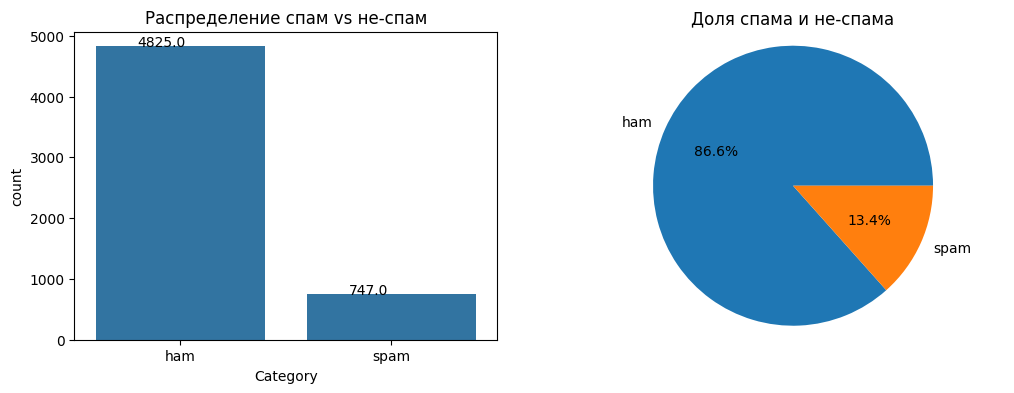

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x='Category', data=spam_df, ax=axes[0])
axes[0].set_title('Распределение спам vs не-спам')
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+5))

category_counts = spam_df['Category'].value_counts()
axes[1].pie(category_counts, labels = category_counts.index, autopct='%1.1f%%')
axes[1].set_title('Доля спама и не-спама')
axes[1].axis('equal')

plt.show()

Виден сильный дисбаланс классов

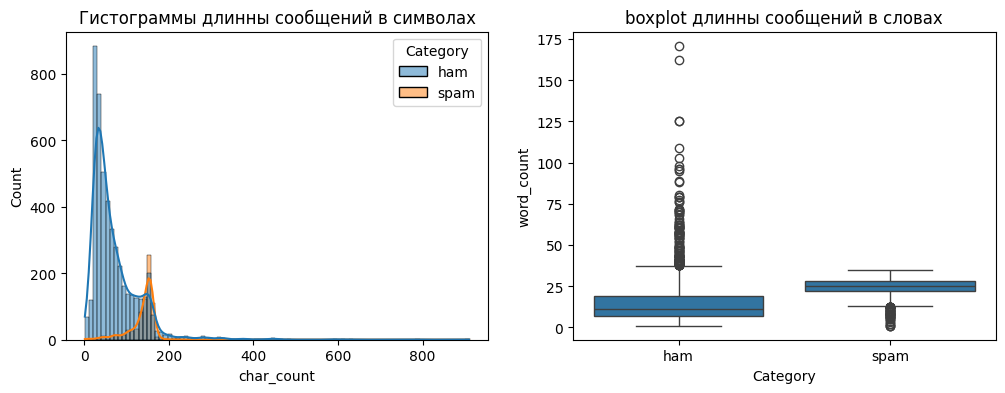

In [ ]:
spam_df['char_count'] = spam_df['Message'].str.len()
spam_df['word_count'] = spam_df['Message'].str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data=spam_df, x='char_count', hue='Category', ax=axes[0], kde=True)
sns.boxplot(data=spam_df, x='Category', y='word_count', ax=axes[1])
axes[0].set_title('Гистограммы длинны сообщений в символах')
axes[1].set_title('boxplot длинны сообщений в словах')
plt.show()

распределение спама сильно отличается от не спама, как по длинне сообщения, так и по количеству символов, судя по графикам спам несколько длиннее

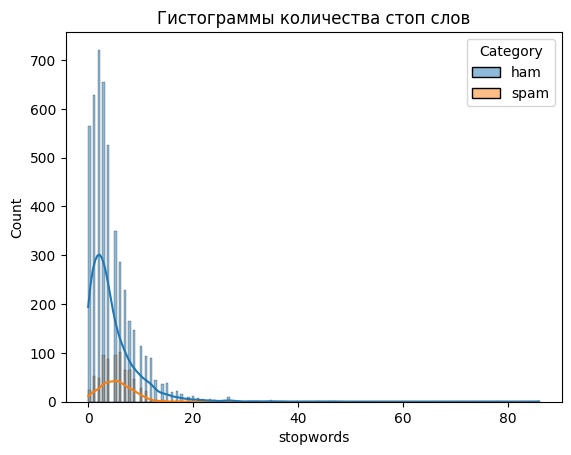

In [ ]:
stop=stopwords.words('english')
spam_df['stopwords']=spam_df['Message'].apply(lambda sen:len([x for x in sen.split() if x in stop]))

sns.histplot(data=spam_df, x='stopwords', hue='Category', kde=True)
plt.title('Гистограммы количества стоп слов')
plt.show()

спам отличается от не спама по количеству стоп слов и чисел в тексте

Всего ссылок: 106 — из них в спаме: 104 (98.1%)
Всего номеров: 435 — из них в спаме: 434 (99.8%)


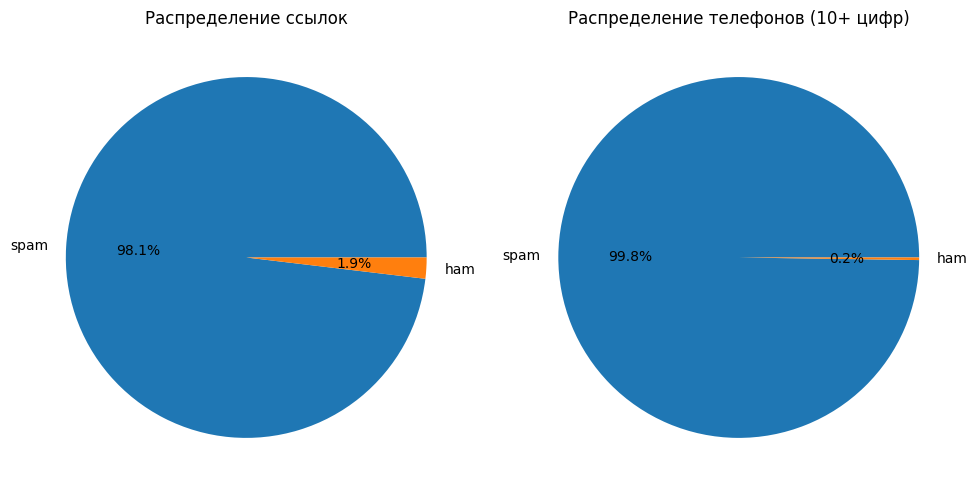

In [ ]:
pattern_link = r'https?://\S+|www\.\S+'
pattern_phone = r'\d{10,}'

spam_df['link_count'] = spam_df['Message'].str.count(pattern_link)
spam_df['phone_count'] = spam_df['Message'].str.count(pattern_phone)

total_links = spam_df['link_count'].sum()
total_phones = spam_df['phone_count'].sum()

spam_mask = spam_df['Category'] == 'spam'

spam_links = spam_df.loc[spam_mask, 'link_count'].sum()
spam_phones = spam_df.loc[spam_mask, 'phone_count'].sum()

ham_links = total_links - spam_links
ham_phones = total_phones - spam_phones

print(f"Всего ссылок: {total_links} — из них в спаме: {spam_links} ({spam_links/total_links:.1%})")
print(f"Всего номеров: {total_phones} — из них в спаме: {spam_phones} ({spam_phones/total_phones:.1%})")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(
    [spam_links, ham_links],
    labels=['spam', 'ham'],
    autopct='%1.1f%%'
)
axes[0].set_title('Распределение ссылок')

axes[1].pie(
    [spam_phones, ham_phones],
    labels=['spam', 'ham'],
    autopct='%1.1f%%'
)
axes[1].set_title('Распределение телефонов (10+ цифр)')

plt.tight_layout()
plt.show()

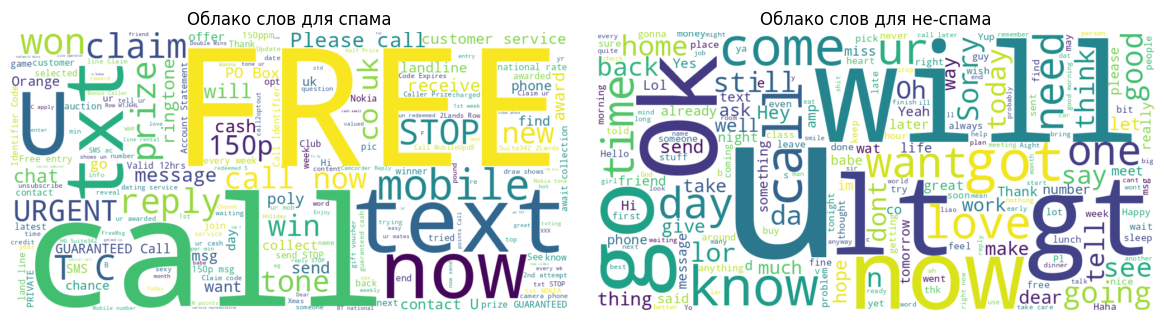

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=1000)
X = vectorizer.fit_transform(spam_df['Message'])
features = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)
top = sorted(zip(counts, features), reverse=True)[:20]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

wordcloud_spam = WordCloud(width=1000, height=500, background_color='white')
wordcloud_spam.generate(" ".join(spam_df.query("Category=='spam'")['Message']))

axes[0].imshow(wordcloud_spam, interpolation='bilinear')
axes[0].set_title('Облако слов для спама')
axes[0].axis('off')

wordcloud_ham = WordCloud(width=1000, height=500, background_color='white')
wordcloud_ham.generate(" ".join(spam_df.query("Category=='ham'")['Message']))

axes[1].imshow(wordcloud_ham, interpolation='bilinear')
axes[1].set_title('Облако слов для не-спама')
axes[1].axis('off')

plt.tight_layout(pad=2.0)
plt.show()


In [ ]:
spam_df.sample(5)

,Category,Message,char_count,word_count,stopwords,link_count,phone_count
5381,spam,You have 1 new message. Call 0207-083-6089,42,7,1,0,0
1508,ham,"Wen ur lovable bcums angry wid u, dnt take it ...",179,34,6,0,0
4816,ham,no home work to do meh...,26,6,3,0,0
2005,ham,"Goodmorning, today i am late for &lt;DECIMAL&...",54,8,3,0,0
2534,ham,Glad it went well :) come over at 11 then we'l...,95,20,9,0,0


## 1.3 Аналитика и предобработка

In [ ]:
def clean_with_bs(s):
    s = html.unescape(s)
    return BeautifulSoup(s, 'html.parser').get_text(separator=' ')

spam_df['Message'] = spam_df['Message'].map(lambda x: clean_with_bs(x) if isinstance(x, str) else x)

удалили все html теги, не несущие смысловой нагрузки.

Функция clean_with_bs берет строку, содержащую HTML-код, парсит ее с помощью BeautifulSoup, а затем извлекает весь текст из HTML, удаляя все теги и атрибуты. Затем функция применяется к столбцу Message, обрабатывая ячейки.

BeautifulSoup выбран как самый простой вариант уже имеющий базу тегов.

In [ ]:
spam_df['Message'] = spam_df['Message'].str.lower()#1

spam_df['Message'] = spam_df['Message'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))#2

spam_df['Message'] = spam_df['Message'].str.replace(pattern_link, '', regex=True)#3

template = '|'.join(map(re.escape, bad_symbols['character']))#4
spam_df['Message'] = spam_df['Message'].str.replace(template, '', regex=True, flags=re.UNICODE)

spam_df['Message'] = spam_df['Message'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))#5

temp_df = pd.Series(' '.join(spam_df['Message']).split()).value_counts()#6
drops = temp_df[temp_df <= 1]
spam_df['rare_words'] = drops
spam_df['Message'] = spam_df['Message'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

1) приводим все к нижнему регистру (чтобы слова содержащие заглавные буквы и не содержащие не считались разными)

2)удаляем все стоп слова т.к. оин не либо не несут смысла сами по себе, либо являются общеупотребительными и не дают контекста

3)удаляем все ссылки, из предположения что 1 ссылка не будет встречаться в датасете несколько раз, следовательно поступаем также как и с редкими словами (в целом не обязательный шаг т.к. удаление редких слов (6) удаляет, и номера, и ссылки)

4)пересоздаем template и удаляем все символы не являющиеся буквами или цифрами, так как они не добавляют никакой дополнительной информации к текстовым данным

5)проводим лемматизацию т.е. приведение слов к общему корню, чтобы не считать слова например с разными окончаниями, разными словами

6)удаляем все слова встречающиеся только 1 раз, т.к. Поскольку они встречаются редко, связь между ними и другими словами в основном шумовая

In [ ]:
#spam_df['Message'] = spam_df['Message'].apply(lambda x: str(TextBlob(x).correct()))

намеренно закомментировал т.к. непонятно почему исправление орфографии сильно снижает итоговые метрики

In [ ]:
freq=pd.Series(' '.join(spam_df['Message']).split()).value_counts()[:10]
freq

,count
u,1193
call,599
2,482
get,397
ur,390
go,307
4,293
ok,278
free,276
know,267


не стал удалять самые часто встречающиеся слова т.к. как видно из облак слов, они дают сильное представление о том спам это или нет

In [ ]:
spam_df['Category'] = np.where(spam_df['Category']=="spam",1,0)

простой label encoding, так как в бинарной классификации OH encoding будет избыточен, тут 1 спам, 0 не спам

# 2. Построение моделей

## 2.1 Выбор метрики

Необходимо выбрать метрики оценки работы моделей.
Основная задача стоит в том, чтобы минимизировать количество недетектированных спамов

Т.к. главная цель найти как можно больше спама, то есть свести к минимуму false negatives.

Основной метрикой будет полнота (Recall), поскольку напрямую отражает долю реально существующего спама.


Precision важна для баланса моделей (например чтобы модель не начала закидывать в спам все письма)

Precision-Recall AUC фокусируется именно на балансе P/R, а не на TN, что важно при сильном дисбалансе классов

## 2.2 Разбиение на выборки

In [ ]:
X = spam_df.drop(columns='Category')
y = spam_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Разделение данных на тренировочные и тестовые помогает избежать переобучения (overfitting) и обеспечивает объективную оценку производительности модели.


## 2.3 Обучение

### 2.3.1 Простые модели
Попробуем решить задачу простыми ML методами

In [ ]:
def simple_model_pipeline(model,
                          param_grid,
                          vectorizer,
                          X_train, y_train,
                          X_test,  y_test,
                          numeric_cols,
                          P0=0.8,
                          model_name=''):

    get_text = FunctionTransformer(lambda df: df['Message'], validate=False)
    get_num  = FunctionTransformer(lambda df: df[numeric_cols].values, validate=False)

    features = FeatureUnion([
        ('tfidf',  Pipeline([
            ('extract_text', get_text),
            ('vect',         vectorizer)
        ])),
        ('num',    Pipeline([
            ('extract_num',  get_num),
            ('scale',        StandardScaler())
        ]))
    ])

    pipeline = Pipeline([
        ('features', features),
        ('clf',      model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipeline,
                        param_grid,
                        scoring='recall',
                        cv=cv,
                        n_jobs=-1)

    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    best = grid.best_estimator_
    probs = best.predict_proba(X_test)[:, 1]
    prec, rec, thresholds = precision_recall_curve(y_test, probs)

    mask = prec[:-1] >= P0

    if mask.any():
        rec_masked   = rec[:-1][mask]
        thresholds_masked = thresholds[mask]
        best_idx     = np.argmax(rec_masked)
        best_thr     = thresholds_masked[best_idx]
    else:
        best_thr = thresholds[np.argmax(prec[:-1])]

    y_pred = (probs >= best_thr).astype(int)

    print(f"Selected threshold: {best_thr:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    pt_prec = prec[:-1][mask][best_idx] if mask.any() else prec[np.argmax(prec[:-1])]
    pt_rec  = rec[:-1][mask][best_idx]  if mask.any() else rec[np.argmax(prec[:-1])]

    roc_figure(prec, rec, pt_prec, pt_rec, model_name)

    return [y_pred, prec, rec, pt_prec, pt_rec], best

def roc_figure(prec, rec, pt_prec, pt_rec, model_name):
    plt.figure(figsize=(6,4))
    plt.plot(prec, rec, label='PR-curve')

    plt.scatter(pt_prec, pt_rec, color='red',
                label=f'Chosen point\nP={pt_prec:.2f}, R={pt_rec:.2f}')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
vectorizer = TfidfVectorizer(
          max_features = 5000,
          ngram_range  = (1,2),
          min_df       = 5,
          max_df       = 0.8,
          sublinear_tf = True,
          strip_accents= 'unicode'
      )
vectorizer.fit(X_train['Message'])

TfidfVectorizer(max_df=0.8, max_features=5000, min_df=5, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best params: {'clf__C': 0.1, 'clf__kernel': 'linear', 'features__tfidf__vect__min_df': 10, 'features__tfidf__vect__ngram_range': (1, 2)}
Selected threshold: 0.156
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1448
           1       0.80      0.95      0.87       224

    accuracy                           0.96      1672
   macro avg       0.90      0.95      0.92      1672
weighted avg       0.97      0.96      0.96      1672

Confusion Matrix:
 [[1395   53]
 [  12  212]]


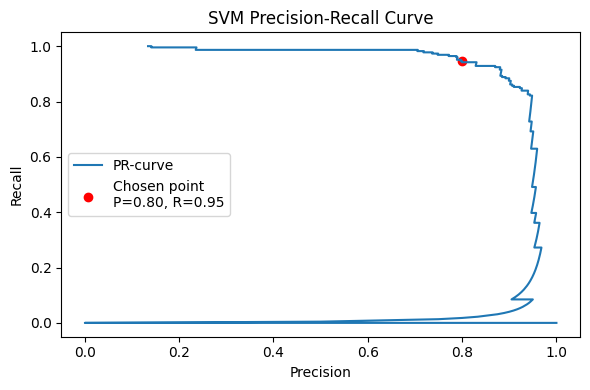

In [ ]:
param_grid = {
    'features__tfidf__vect__ngram_range': [(1,1),(1,2)],
    'features__tfidf__vect__min_df':      [3,5,10],
    'clf__C':                             [0.1,1,10],
    'clf__kernel':                        ['linear','rbf']
}

svm_model = svm.SVC(
          class_weight = 'balanced',
          probability=True,
          max_iter     = 1000,
          random_state = 42
          )

numeric_cols = ['link_count','phone_count','char_count','word_count','stopwords']

svm_result, svm_best_params = simple_model_pipeline(svm_model, param_grid, vectorizer, X_train, y_train,
                                                    X_test, y_test, numeric_cols, model_name='SVM')

Эффективен в задачах с высокой размерностью (TF–IDF), т.к. хорошо работает на разреженных векторах признаков.

принцип работы: svm с помощью ядер переходит к пространству более высокой размерности в которых выборка будет линейно разделима, разделяющая гиперплоскость определяется опорными векторами (по принципу максимального удаления от границ)

Best params: {'clf__C': 10, 'clf__l1_ratio': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'features__tfidf__vect__min_df': 3, 'features__tfidf__vect__ngram_range': (1, 1)}
Selected threshold: 0.219
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1448
           1       0.80      0.96      0.87       224

    accuracy                           0.96      1672
   macro avg       0.90      0.96      0.93      1672
weighted avg       0.97      0.96      0.96      1672

Confusion Matrix:
 [[1394   54]
 [   8  216]]


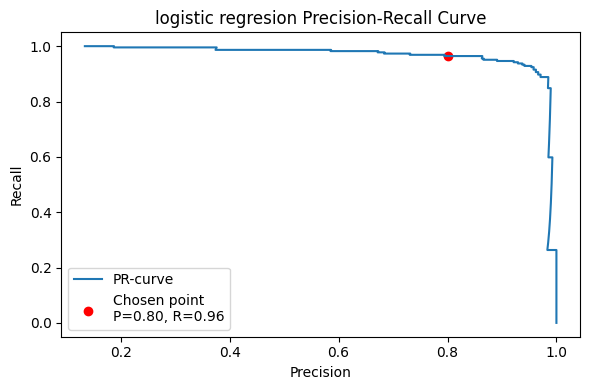

In [ ]:
param_grid_lr = {
    'features__tfidf__vect__ngram_range': [(1,1), (1,2)],
    'features__tfidf__vect__min_df':      [3, 5, 7],

    'clf__solver':   ['liblinear'],
    'clf__penalty':  ['l2', 'l1'],
    'clf__C':        [0.1, 1, 10],

    'clf__l1_ratio': [None, 0.5],
}

lr_model = LogisticRegression(
          class_weight = 'balanced',
          max_iter     = 1000,
          random_state = 42
          )
log_reg_result, log_reg_best_params = simple_model_pipeline(lr_model, param_grid_lr, vectorizer, X_train,
                                                            y_train, X_test, y_test, numeric_cols, model_name='logistic regresion')

интерпретируема и так же хорошо работает с высокоразмерными данными


принцип работы: находим прямую линейной регресии и применяем к ней сигмоиду

Best params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 5, 'clf__weights': 'distance', 'features__tfidf__vect__max_df': 0.8, 'features__tfidf__vect__min_df': 5, 'features__tfidf__vect__ngram_range': (1, 1)}
Selected threshold: 0.203
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1448
           1       0.80      0.93      0.86       224

    accuracy                           0.96      1672
   macro avg       0.90      0.95      0.92      1672
weighted avg       0.96      0.96      0.96      1672

Confusion Matrix:
 [[1396   52]
 [  15  209]]


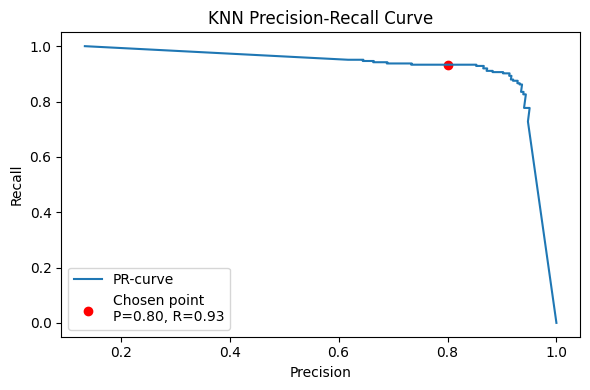

In [ ]:
param_grid_knn = {

    'features__tfidf__vect__ngram_range': [(1,1), (1,2)],
    'features__tfidf__vect__min_df':      [3, 5],
    'features__tfidf__vect__max_df':      [0.8, 0.9],

    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights':     ['uniform', 'distance'],
    'clf__metric':      ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier(n_jobs=-1)

knn_result, knn_best_params = simple_model_pipeline(knn_model, param_grid_knn, vectorizer,
                                                    X_train, y_train, X_test, y_test, numeric_cols, model_name  = 'KNN')

простой, хорошо работает с высокими размерностями, спам сообщения образуют кластеры, а knn хорошо улавливает такие зависимости

принцип работы: вычисляем расстояние от нового элемента до каждого уже  размеченного, класс нового элемента определяется большинством классов из ближайших элементов

### 2.3.2 Собственная НС

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self,
                 dataframe,
                 category,
                 tokenizer,
                 max_len=None):

        self.data     = dataframe.reset_index(drop=True)
        self.labels   = torch.tensor(category.values, dtype=torch.long)
        self.tokenizer= tokenizer
        self.max_len  = max_len

        if hasattr(self.tokenizer, 'transform') and not hasattr(self.tokenizer, 'encode_plus'):
            tfidf_matrix = self.tokenizer.transform(self.data['Message'])
            self.tfidf = tfidf_matrix
        else:
            self.tfidf = None

        nums = ['char_count','word_count','phone_count','stopwords', 'link_count']
        num_arr = dataframe[nums].values.astype(float)
        self.numeric_feats = torch.tensor(num_arr, dtype=torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {'category': self.labels[idx]}

        item['numerical_features'] = self.numeric_feats[idx]

        if self.tfidf is not None:

            row = self.tfidf[idx].toarray().squeeze()
            item['input_ids'] = torch.tensor(row, dtype=torch.float)
            item['attention_mask'] = torch.tensor([])
        else:
            text = str(self.data.loc[idx, 'Message'])
            inputs = self.tokenizer.encode_plus(
                text,
                None,
                add_special_tokens  = True,
                max_length          = self.max_len,
                padding             = 'max_length',
                truncation          = True,
                return_attention_mask = True,
                return_tensors      = 'pt'
            )
            item['input_ids']      = inputs['input_ids'].squeeze(0)
            item['attention_mask']= inputs['attention_mask'].squeeze(0)

        return item
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128

train_dataset = TextClassificationDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True), tokenizer, MAX_LEN)
test_dataset = TextClassificationDataset(X_test.reset_index(drop=True), y_test.reset_index(drop=True), tokenizer, MAX_LEN)

BATCH_SIZE = 128
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def train_model(model,
                train_dataloader,
                val_dataloader,
                epochs,
                learning_rate,
                device,
                threshold=0.5,
                save_path='best_model.pt',
                scheduler_factor=0.5,
                scheduler_patience=2,
                early_stop_patience=3):

    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(
        optimizer, mode='max',
        factor=scheduler_factor,
        patience=scheduler_patience,
        verbose=True
    )

    history = {
        'train_loss': [], 'train_prec': [], 'train_rec': [], 'train_pr_auc': [],
        'val_loss': [],   'val_prec': [],   'val_rec':   [],   'val_pr_auc':   []
    }

    best_val_rec = -float('inf')
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        print(f"\nЭпоха {epoch}/{epochs}")

        # ——— TRAІNING STEP ———
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        for batch in tqdm(train_dataloader, desc="  Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical = [t.to(device) for t in batch['numerical_features']]
            labels = batch['category'].to(device).float()

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask, numerical)
            loss = criterion(logits.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
            preds = (probs >= threshold).astype(int)

            all_probs.extend(probs.tolist())
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().long().numpy().tolist())

        train_loss = running_loss / len(train_dataloader)
        train_prec = precision_score(all_labels, all_preds, zero_division=0)
        train_rec  = recall_score(all_labels, all_preds, zero_division=0)
        train_pr_auc = average_precision_score(all_labels, all_probs)

        history['train_loss'].append(train_loss)
        history['train_prec'].append(train_prec)
        history['train_rec'].append(train_rec)
        history['train_pr_auc'].append(train_pr_auc)

        print(f"  TRAIN loss={train_loss:.4f} "
              f"P={train_prec:.3f} R={train_rec:.3f} PR-AUC={train_pr_auc:.3f}")

        # ——— VALIDATION STEP ———
        if val_dataloader is not None:
            model.eval()
            running_loss = 0.0
            all_labels, all_probs, all_preds = [], [], []

            with torch.no_grad():
                for batch in tqdm(val_dataloader, desc="  Validation"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    numerical = [t.to(device) for t in batch['numerical_features']]
                    labels = batch['category'].to(device).float()

                    logits = model(input_ids, attention_mask, numerical)
                    loss = criterion(logits.squeeze(), labels)
                    running_loss += loss.item()

                    probs = torch.sigmoid(logits).cpu().numpy().ravel()
                    preds = (probs >= threshold).astype(int)

                    all_probs.extend(probs.tolist())
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.cpu().long().numpy().tolist())

            val_loss = running_loss / len(val_dataloader)
            val_prec = precision_score(all_labels, all_preds, zero_division=0)
            val_rec  = recall_score(all_labels, all_preds, zero_division=0)
            val_pr_auc = average_precision_score(all_labels, all_probs)

            history['val_loss'].append(val_loss)
            history['val_prec'].append(val_prec)
            history['val_rec'].append(val_rec)
            history['val_pr_auc'].append(val_pr_auc)

            print(f"  VAL   loss={val_loss:.4f} "
                  f"P={val_prec:.3f} R={val_rec:.3f} PR-AUC={val_pr_auc:.3f}")

            cm = confusion_matrix(all_labels, all_preds)
            print("\n  Confusion Matrix (val):")
            print(cm)

            scheduler.step(val_rec)

            if val_rec > best_val_rec:
                best_val_rec = val_rec
                epochs_no_improve = 0
                torch.save(model.state_dict(), save_path)
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stop_patience:
                    print(f"\nEarly stopping: "
                          f"no improvement for {early_stop_patience} epochs.")
                    break

    print("\nTraining complete. "
          f"Best val recall: {best_val_rec:.3f}")
    model.load_state_dict(torch.load(save_path))
    return history


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim,num_numerical_features,
                 output_dim=1,n_extra_layers = 1, dropout=0.3):
        super().__init__()

        blocks = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        ]

        for _ in range(n_extra_layers):
            blocks += [
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.LayerNorm(hidden_dim)
            ]

        self.hidden_blocks = nn.Sequential(*blocks)

        self.out = nn.Linear(hidden_dim, output_dim)

        self.feat_proj = nn.Sequential(
            nn.LayerNorm(num_numerical_features),
            nn.Linear(num_numerical_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )



    def forward(self, x, att_mask, numerical):
        numerical_features = torch.stack(numerical, dim=1)
        numerical_features = numerical_features.transpose(0,1)
        feats = self.feat_proj(numerical_features)

        x = torch.cat([x, feats], dim=-1)

        x = self.hidden_blocks(x)

        logits = self.out(x)
        probs  = torch.sigmoid(logits).squeeze(1)
        return logits

vectorizer.fit(X_train['Message'])
tfidf_dim = vectorizer.transform(X_train['Message']).shape[1]
num_numerical_features = 5
input_dim = tfidf_dim+num_numerical_features

mlp = SimpleMLP(input_dim=1853, hidden_dim=224,
                num_numerical_features=num_numerical_features, n_extra_layers = 3, dropout=0.3)

train_dataset = TextClassificationDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True), vectorizer, MAX_LEN)
test_dataset = TextClassificationDataset(X_test.reset_index(drop=True), y_test.reset_index(drop=True), vectorizer, MAX_LEN)

BATCH_SIZE = 128
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.008
history = train_model(mlp, train_data_loader, test_data_loader, epochs, learning_rate,
                device, scheduler_patience=10,
                early_stop_patience=25, )


Эпоха 1/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 51.11it/s]


  TRAIN loss=0.0123 P=0.996 R=0.990 PR-AUC=0.995


  Validation: 100%|██████████| 14/14 [00:00<00:00, 69.24it/s]


  VAL   loss=0.2183 P=0.864 R=0.933 PR-AUC=0.841

  Confusion Matrix (val):
[[1415   33]
 [  15  209]]

Эпоха 2/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.22it/s]


  TRAIN loss=0.0104 P=0.990 R=0.990 PR-AUC=0.996


  Validation: 100%|██████████| 14/14 [00:00<00:00, 66.87it/s]


  VAL   loss=0.3001 P=0.819 R=0.929 PR-AUC=0.953

  Confusion Matrix (val):
[[1402   46]
 [  16  208]]

Эпоха 3/100


  Training: 100%|██████████| 31/31 [00:01<00:00, 25.53it/s]


  TRAIN loss=0.0144 P=0.992 R=0.985 PR-AUC=0.997


  Validation: 100%|██████████| 14/14 [00:00<00:00, 24.42it/s]


  VAL   loss=0.1686 P=0.923 R=0.911 PR-AUC=0.959

  Confusion Matrix (val):
[[1431   17]
 [  20  204]]

Эпоха 4/100


  Training: 100%|██████████| 31/31 [00:01<00:00, 18.80it/s]


  TRAIN loss=0.0198 P=0.986 R=0.977 PR-AUC=0.990


  Validation: 100%|██████████| 14/14 [00:00<00:00, 18.46it/s]


  VAL   loss=0.2046 P=0.832 R=0.951 PR-AUC=0.963

  Confusion Matrix (val):
[[1405   43]
 [  11  213]]

Эпоха 5/100


  Training: 100%|██████████| 31/31 [00:02<00:00, 11.48it/s]


  TRAIN loss=0.0073 P=0.994 R=0.990 PR-AUC=0.999


  Validation: 100%|██████████| 14/14 [00:00<00:00, 33.49it/s]


  VAL   loss=0.1597 P=0.912 R=0.929 PR-AUC=0.962

  Confusion Matrix (val):
[[1428   20]
 [  16  208]]

Эпоха 6/100


  Training: 100%|██████████| 31/31 [00:01<00:00, 28.26it/s]


  TRAIN loss=0.0071 P=0.996 R=0.992 PR-AUC=0.997


  Validation: 100%|██████████| 14/14 [00:00<00:00, 66.51it/s]


  VAL   loss=0.1485 P=0.966 R=0.897 PR-AUC=0.959

  Confusion Matrix (val):
[[1441    7]
 [  23  201]]

Эпоха 7/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.32it/s]


  TRAIN loss=0.0056 P=0.998 R=0.990 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.80it/s]


  VAL   loss=0.1495 P=0.948 R=0.902 PR-AUC=0.960

  Confusion Matrix (val):
[[1437   11]
 [  22  202]]

Эпоха 8/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.73it/s]


  TRAIN loss=0.0068 P=1.000 R=0.990 PR-AUC=0.999


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.23it/s]


  VAL   loss=0.1849 P=0.909 R=0.933 PR-AUC=0.965

  Confusion Matrix (val):
[[1427   21]
 [  15  209]]

Эпоха 9/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 52.95it/s]


  TRAIN loss=0.0059 P=0.998 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.24it/s]


  VAL   loss=0.1550 P=0.953 R=0.906 PR-AUC=0.954

  Confusion Matrix (val):
[[1438   10]
 [  21  203]]

Эпоха 10/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.68it/s]


  TRAIN loss=0.0065 P=0.996 R=0.989 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 65.98it/s]


  VAL   loss=0.2208 P=0.896 R=0.920 PR-AUC=0.957

  Confusion Matrix (val):
[[1424   24]
 [  18  206]]

Эпоха 11/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 56.02it/s]


  TRAIN loss=0.0041 P=0.998 R=0.994 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 66.39it/s]


  VAL   loss=0.2033 P=0.944 R=0.911 PR-AUC=0.936

  Confusion Matrix (val):
[[1436   12]
 [  20  204]]

Эпоха 12/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.51it/s]


  TRAIN loss=0.0039 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.47it/s]


  VAL   loss=0.2589 P=0.892 R=0.920 PR-AUC=0.944

  Confusion Matrix (val):
[[1423   25]
 [  18  206]]

Эпоха 13/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 51.77it/s]


  TRAIN loss=0.0143 P=0.998 R=0.985 PR-AUC=0.997


  Validation: 100%|██████████| 14/14 [00:00<00:00, 65.11it/s]


  VAL   loss=0.1565 P=0.932 R=0.911 PR-AUC=0.957

  Confusion Matrix (val):
[[1433   15]
 [  20  204]]

Эпоха 14/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.64it/s]


  TRAIN loss=0.0100 P=0.992 R=0.994 PR-AUC=0.998


  Validation: 100%|██████████| 14/14 [00:00<00:00, 63.65it/s]


  VAL   loss=0.2085 P=0.861 R=0.938 PR-AUC=0.914

  Confusion Matrix (val):
[[1414   34]
 [  14  210]]

Эпоха 15/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.25it/s]


  TRAIN loss=0.0074 P=0.996 R=0.990 PR-AUC=0.999


  Validation: 100%|██████████| 14/14 [00:00<00:00, 70.04it/s]


  VAL   loss=0.1379 P=0.932 R=0.920 PR-AUC=0.959

  Confusion Matrix (val):
[[1433   15]
 [  18  206]]

Эпоха 16/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 44.21it/s]


  TRAIN loss=0.0049 P=1.000 R=0.992 PR-AUC=0.999


  Validation: 100%|██████████| 14/14 [00:00<00:00, 47.95it/s]


  VAL   loss=0.1756 P=0.932 R=0.920 PR-AUC=0.959

  Confusion Matrix (val):
[[1433   15]
 [  18  206]]

Эпоха 17/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 38.89it/s]


  TRAIN loss=0.0040 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 39.82it/s]


  VAL   loss=0.1796 P=0.920 R=0.924 PR-AUC=0.960

  Confusion Matrix (val):
[[1430   18]
 [  17  207]]

Эпоха 18/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 42.63it/s]


  TRAIN loss=0.0037 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.40it/s]


  VAL   loss=0.1820 P=0.936 R=0.915 PR-AUC=0.958

  Confusion Matrix (val):
[[1434   14]
 [  19  205]]

Эпоха 19/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.21it/s]


  TRAIN loss=0.0039 P=1.000 R=0.990 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.75it/s]


  VAL   loss=0.1985 P=0.902 R=0.942 PR-AUC=0.961

  Confusion Matrix (val):
[[1425   23]
 [  13  211]]

Эпоха 20/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 52.68it/s]


  TRAIN loss=0.0038 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 63.75it/s]


  VAL   loss=0.1875 P=0.929 R=0.933 PR-AUC=0.961

  Confusion Matrix (val):
[[1432   16]
 [  15  209]]

Эпоха 21/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 52.64it/s]


  TRAIN loss=0.0033 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 65.89it/s]


  VAL   loss=0.1913 P=0.929 R=0.933 PR-AUC=0.961

  Confusion Matrix (val):
[[1432   16]
 [  15  209]]

Эпоха 22/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.68it/s]


  TRAIN loss=0.0039 P=0.996 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 61.63it/s]


  VAL   loss=0.1774 P=0.948 R=0.902 PR-AUC=0.960

  Confusion Matrix (val):
[[1437   11]
 [  22  202]]

Эпоха 23/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.35it/s]


  TRAIN loss=0.0038 P=0.998 R=0.994 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 69.01it/s]


  VAL   loss=0.1827 P=0.928 R=0.924 PR-AUC=0.964

  Confusion Matrix (val):
[[1432   16]
 [  17  207]]

Эпоха 24/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.37it/s]


  TRAIN loss=0.0037 P=1.000 R=0.994 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 63.92it/s]


  VAL   loss=0.1825 P=0.932 R=0.924 PR-AUC=0.961

  Confusion Matrix (val):
[[1433   15]
 [  17  207]]

Эпоха 25/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 52.82it/s]


  TRAIN loss=0.0029 P=1.000 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 65.08it/s]


  VAL   loss=0.1855 P=0.932 R=0.920 PR-AUC=0.961

  Confusion Matrix (val):
[[1433   15]
 [  18  206]]

Эпоха 26/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 52.83it/s]


  TRAIN loss=0.0034 P=1.000 R=0.994 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 68.60it/s]


  VAL   loss=0.1885 P=0.940 R=0.915 PR-AUC=0.959

  Confusion Matrix (val):
[[1435   13]
 [  19  205]]

Эпоха 27/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 54.33it/s]


  TRAIN loss=0.0033 P=1.000 R=0.994 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 59.65it/s]


  VAL   loss=0.1874 P=0.932 R=0.915 PR-AUC=0.960

  Confusion Matrix (val):
[[1433   15]
 [  19  205]]

Эпоха 28/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.05it/s]


  TRAIN loss=0.0035 P=0.998 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 64.95it/s]


  VAL   loss=0.1844 P=0.936 R=0.915 PR-AUC=0.960

  Confusion Matrix (val):
[[1434   14]
 [  19  205]]

Эпоха 29/100


  Training: 100%|██████████| 31/31 [00:00<00:00, 53.08it/s]


  TRAIN loss=0.0044 P=0.998 R=0.992 PR-AUC=1.000


  Validation: 100%|██████████| 14/14 [00:00<00:00, 56.33it/s]

  VAL   loss=0.2226 P=0.876 R=0.942 PR-AUC=0.965

  Confusion Matrix (val):
[[1418   30]
 [  13  211]]

Early stopping: no improvement for 25 epochs.

Training complete. Best val recall: 0.951


простой многослойный перцептрон с layerNorm dropout и активацией ReLU. feat_proj входной слой - кодирует признаки в скрытое пространство, N  внутренних полносвязных слоев комбинируют фичи и слой классификации классифицирует приводит эти фичи к конкретной оценке вероятности класса

### 2.3.3 Готовая НС

In [ ]:
class BertWithExtraFeatures(nn.Module):
    def __init__(self,
                 model,
                 num_numerical_features,
                 num_labels):
        super().__init__()
        self.bert = model
        hidden_size = model.config.hidden_size

        self.feat_proj = nn.Sequential(
            nn.LayerNorm(num_numerical_features),
            nn.Linear(num_numerical_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_labels)
        )


    def forward(self,
                input_ids,
                attention_mask,
                numerical_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        numerical_features = torch.stack(numerical_features, dim=1)
        numerical_features = numerical_features.transpose(0,1)

        feats = self.feat_proj(numerical_features.to(pooled.device))

        x = torch.cat([pooled, feats], dim=-1)
        logits = self.classifier(x)

        return logits


num_numerical_features = 5
num_labels = 1


base_model = BertModel.from_pretrained('bert-base-uncased')

for p in base_model.embeddings.parameters():
    p.requires_grad = False

freeze_layers = list(range(4))

for idx in freeze_layers:
    layer = base_model.encoder.layer[idx]
    for p in layer.parameters():
        p.requires_grad = False

model = BertWithExtraFeatures(base_model, num_numerical_features, num_labels)

In [ ]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0003

history_BERT = train_model(model, train_data_loader, test_data_loader, epochs, learning_rate,
                      device, scheduler_patience=2, early_stop_patience=3)


Эпоха 1/10


  Training: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


  TRAIN loss=0.2572 P=0.882 R=0.442 PR-AUC=0.652


  Validation: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


  VAL   loss=0.0929 P=0.989 R=0.786 PR-AUC=0.956

  Confusion Matrix (val):
[[1446    2]
 [  48  176]]

Эпоха 2/10


  Training: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


  TRAIN loss=0.0912 P=0.949 R=0.860 PR-AUC=0.938


  Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


  VAL   loss=0.1240 P=0.783 R=0.951 PR-AUC=0.954

  Confusion Matrix (val):
[[1389   59]
 [  11  213]]

Эпоха 3/10


  Training: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


  TRAIN loss=0.0713 P=0.954 R=0.904 PR-AUC=0.958


  Validation: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


  VAL   loss=0.0747 P=1.000 R=0.835 PR-AUC=0.968

  Confusion Matrix (val):
[[1448    0]
 [  37  187]]

Эпоха 4/10


  Training: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]


  TRAIN loss=0.0532 P=0.986 R=0.916 PR-AUC=0.970


  Validation: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


  VAL   loss=0.0817 P=0.914 R=0.906 PR-AUC=0.972

  Confusion Matrix (val):
[[1429   19]
 [  21  203]]

Эпоха 5/10


  Training: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


  TRAIN loss=0.0575 P=0.963 R=0.945 PR-AUC=0.967


  Validation: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


  VAL   loss=0.1492 P=0.740 R=0.951 PR-AUC=0.963

  Confusion Matrix (val):
[[1373   75]
 [  11  213]]

Early stopping: no improvement for 3 epochs.

Training complete. Best val recall: 0.951


BERT с надстройкой 'multi-modal input' для добавления числовых значений, выбран как самый простой и быстрый среди transformer based, если не считать дистилированные модели, так же обладает сильным обученным эмбеддингом. еще эта модель обладает устойчивостью к шуму за счет хорошего токенизатора, так как спам часто содержит сокращения, опечатки.

# 3. Результаты
Подведение итогов

In [ ]:
def collect_log_loss(models: dict,
                     vectorizer: TfidfVectorizer,
                     numeric_cols: list,
                     X: pd.DataFrame,
                     y: pd.Series,
                     cv: int = 5,
                     train_sizes: np.ndarray = None):

    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 5)

    get_text = FunctionTransformer(lambda df: df['Message'], validate=False)
    get_num  = FunctionTransformer(lambda df: df[numeric_cols].values, validate=False)

    feat_pipe = FeatureUnion([
        ('tfidf', Pipeline([
            ('extract_text', get_text),
            ('vect',         vectorizer)
        ])),
        ('num', Pipeline([
            ('extract_num', get_num),
            ('scale',       StandardScaler())
        ]))
    ])

    Xt = feat_pipe.fit_transform(X)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        train_sizes_abs, train_scores, test_scores = learning_curve(
            model,
            Xt, y,
            cv=skf,
            scoring='neg_log_loss',
            train_sizes=train_sizes,
            n_jobs=-1
        )

        train_loss = -train_scores.mean(axis=1)
        val_loss   = -test_scores.mean(axis=1)

        results[name] = {
            'train_sizes': train_sizes_abs,
            'train_loss':  train_loss,
            'val_loss':    val_loss
        }
    return results


def plot_log_loss_curves(curves: dict):
    plt.figure(figsize=(8,6))
    for name, data in curves.items():
        ts = data['train_sizes']
        plt.plot(ts, data['train_loss'], label=f'{name} train')
        plt.plot(ts, data['val_loss'],   label=f'{name} val', linestyle='--')

    plt.xlabel('Размер обучающей выборки')
    plt.ylabel('Log Loss')
    plt.title('Кривые обучения (log loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


numeric_cols = ['link_count','phone_count','char_count','word_count','stopwords']

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=5,
    sublinear_tf=True,
    strip_accents='unicode'
)
#пересоздал с лучшими параметрами полученными из grid search
models = {
    'LogReg': LogisticRegression(
                  C=10,
                  penalty='l2',
                  solver='liblinear',
                  class_weight='balanced',
                  max_iter=1000,
                  random_state=42
              ),
    'SVM':    SVC(
                  C=0.1,
                  kernel='linear',
                  class_weight='balanced',
                  probability=True,
                  random_state=42
              ),
    'KNN':    KNeighborsClassifier(
                  n_neighbors=5,
                  metric='euclidean',
                  weights='distance',
                  n_jobs=-1
              )
}

curves = collect_log_loss(
    models,
    vectorizer,
    numeric_cols,
    X_train, y_train,
    cv=5
)

## 3.1 Метрики
Подвести итоговые метрики на контрольной выборке каждого из выбранных подходов

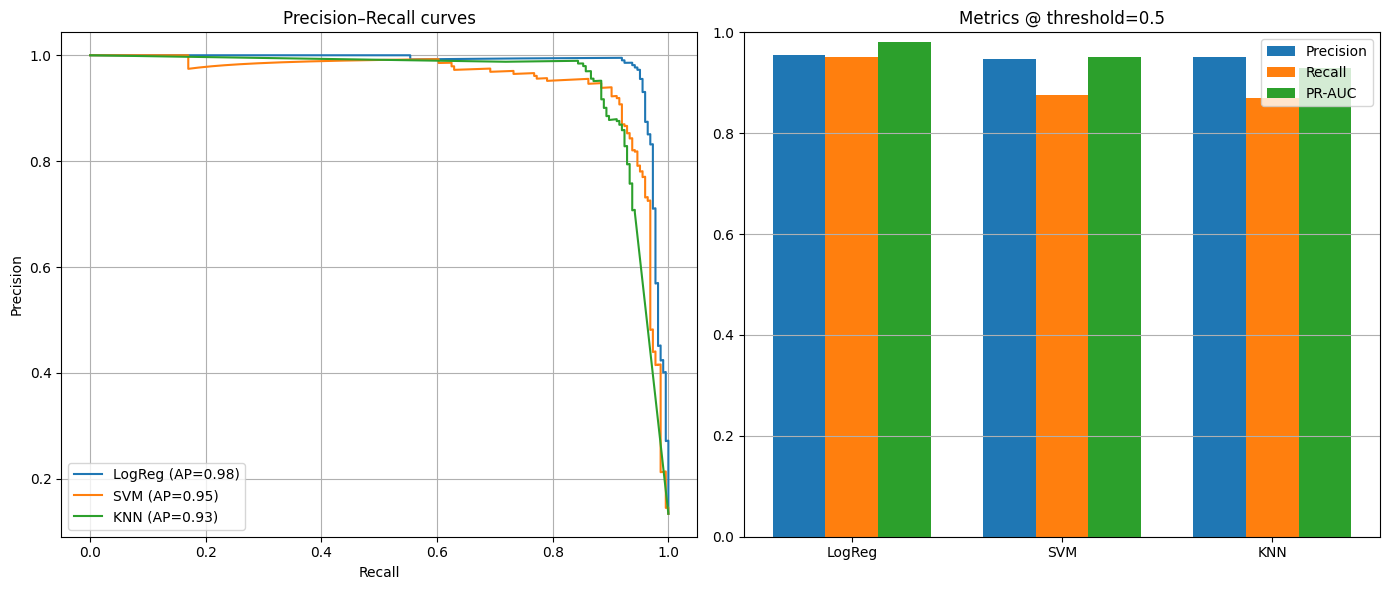

In [ ]:
def evaluate_and_plot(models,
                      X_train, y_train,
                      X_test,  y_test,
                      threshold=0.5):

    plt.figure(figsize=(14,6))


    ax1 = plt.subplot(1,2,1)
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:,1]
        prec, rec, _ = precision_recall_curve(y_test, probs)
        pr_auc = average_precision_score(y_test, probs)
        ax1.plot(rec, prec, label=f"{name} (AP={pr_auc:.2f})")

    ax1.set_title("Precision–Recall curves")
    ax1.set_xlabel("Recall"); ax1.set_ylabel("Precision")
    ax1.legend(); ax1.grid(True)


    ax2 = plt.subplot(1,2,2)
    names, Ps, Rs, AUCs = [], [], [], []
    for name, pipe in models.items():
        probs = pipe.predict_proba(X_test)[:,1]
        preds = (probs >= threshold).astype(int)
        P = precision_score(y_test, preds, zero_division=0)
        R = recall_score(y_test, preds, zero_division=0)
        A = average_precision_score(y_test, probs)
        names.append(name); Ps.append(P); Rs.append(R); AUCs.append(A)

    x = np.arange(len(names))
    w = 0.25
    ax2.bar(x-w, Ps,    width=w, label="Precision")
    ax2.bar(x,   Rs,    width=w, label="Recall")
    ax2.bar(x+w, AUCs,  width=w, label="PR-AUC")

    ax2.set_xticks(x)
    ax2.set_xticklabels(names)
    ax2.set_ylim(0,1)
    ax2.set_title(f"Metrics threshold={threshold}")
    ax2.legend(); ax2.grid(axis='y')

    plt.tight_layout()
    plt.show()

evaluate_and_plot(
    models,
    X_train, y_train,
    X_test,  y_test,
    threshold=0.5
)

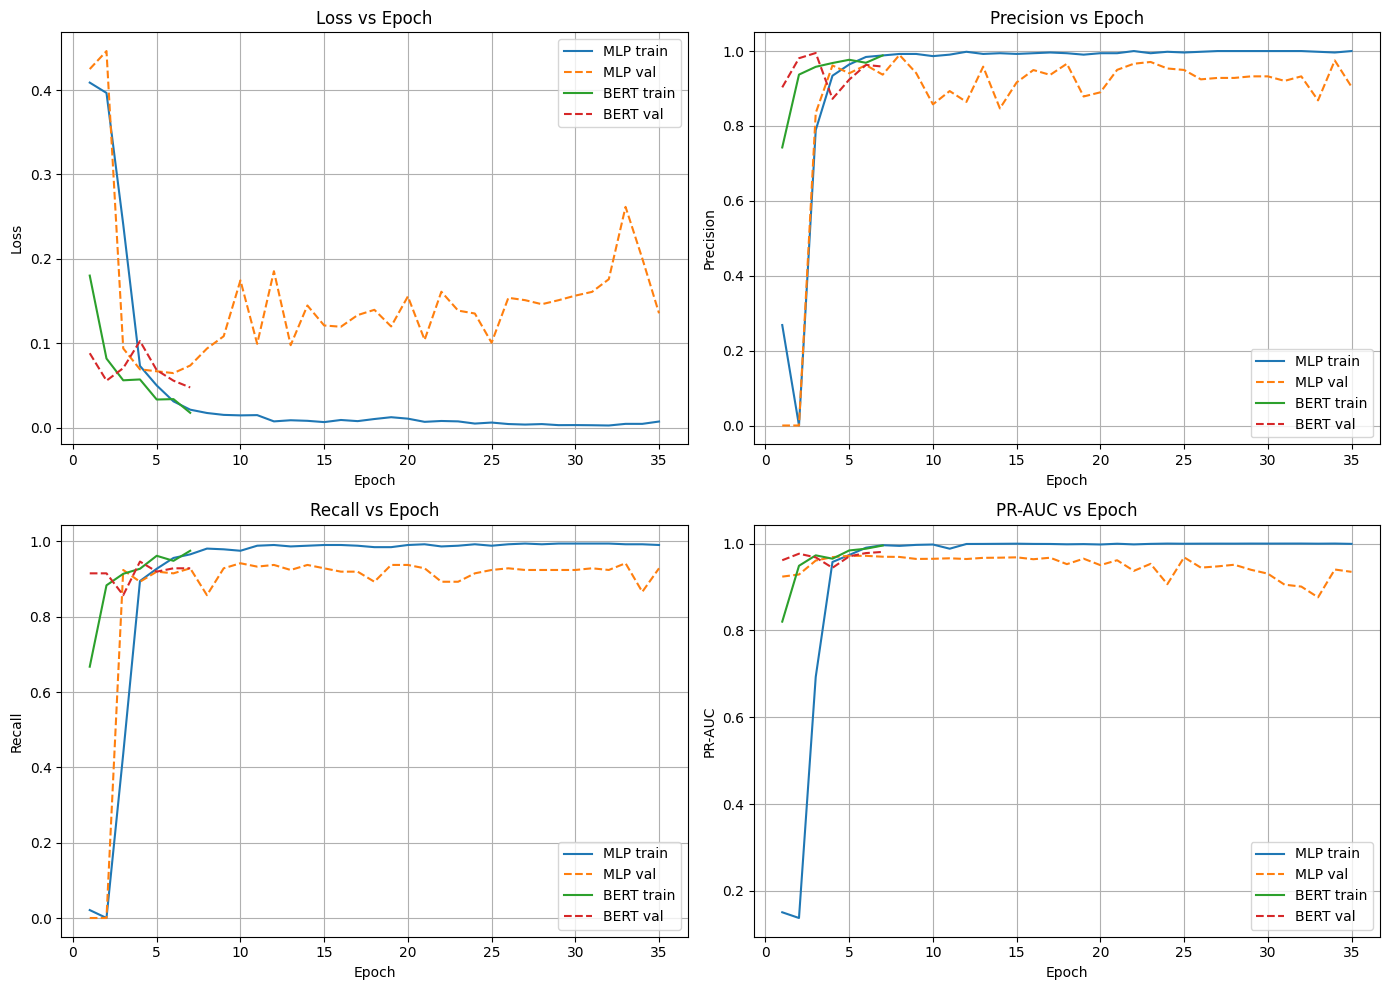

In [ ]:
def plot_training_histories(histories: dict):

    max_epochs = max(len(h['train_loss']) for h in histories.values())
    epochs = list(range(1, max_epochs + 1))

    fig, axes = plt.subplots(2, 2, figsize=(14,10))
    axs = {
        'loss':      axes[0,0],
        'precision': axes[0,1],
        'recall':    axes[1,0],
        'pr_auc':    axes[1,1],
    }

    for name, h in histories.items():
        ep = list(range(1, len(h['train_loss'])+1))


        axs['loss'].plot(ep, h['train_loss'],   label=f"{name} train",   linestyle='-')
        axs['loss'].plot(ep, h['val_loss'],     label=f"{name} val",     linestyle='--')

        axs['precision'].plot(ep, h['train_prec'], label=f"{name} train", linestyle='-')
        axs['precision'].plot(ep, h['val_prec'],   label=f"{name} val",   linestyle='--')

        axs['recall'].plot(ep, h['train_rec'],  label=f"{name} train",   linestyle='-')
        axs['recall'].plot(ep, h['val_rec'],    label=f"{name} val",     linestyle='--')

        axs['pr_auc'].plot(ep, h['train_pr_auc'], label=f"{name} train", linestyle='-')
        axs['pr_auc'].plot(ep, h['val_pr_auc'],   label=f"{name} val",   linestyle='--')

    axs['loss'].set_title("Loss vs Epoch")
    axs['loss'].set_xlabel("Epoch")
    axs['loss'].set_ylabel("Loss")
    axs['loss'].legend()
    axs['loss'].grid(True)

    axs['precision'].set_title("Precision vs Epoch")
    axs['precision'].set_xlabel("Epoch")
    axs['precision'].set_ylabel("Precision")
    axs['precision'].legend()
    axs['precision'].grid(True)

    axs['recall'].set_title("Recall vs Epoch")
    axs['recall'].set_xlabel("Epoch")
    axs['recall'].set_ylabel("Recall")
    axs['recall'].legend()
    axs['recall'].grid(True)

    axs['pr_auc'].set_title("PR-AUC vs Epoch")
    axs['pr_auc'].set_xlabel("Epoch")
    axs['pr_auc'].set_ylabel("PR-AUC")
    axs['pr_auc'].legend()
    axs['pr_auc'].grid(True)

    plt.tight_layout()
    plt.show()



histories = {
    "MLP" : history,
    "BERT": history_BERT
}

plot_training_histories(histories)

## 3.2 Loss
Привести графики обучения (изменения `loss` функции) каждого из выбранных методов

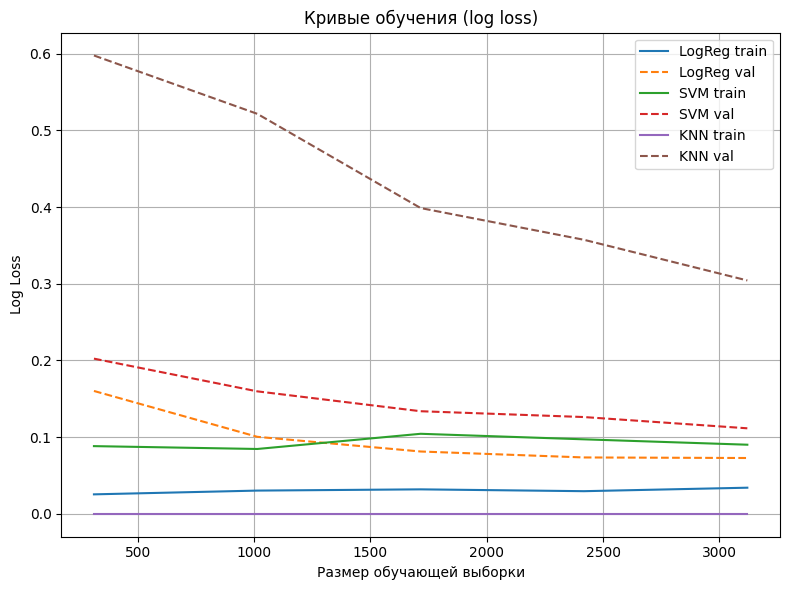

In [ ]:
plot_log_loss_curves(curves)#